### **1.1. Importación de Módulos Esenciales**
Cargamos pandas (datos), numpy (numérico) y los vectorizadores de texto de sklearn (`CountVectorizer`, `TfidfVectorizer`) necesarios para el procesamiento de lenguaje natural.

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

### **1.2. Carga de Datasets Preprocesados**
Cargamos los cinco archivos CSV preprocesados que contienen datos de toxicidad, toxicidad multilingüe y *spam* para su uso en el análisis y modelado.

In [4]:
english_paradetox_df = pd.read_csv("datos/english_paradetox_preprocessed.csv")
english_multilingual_toxicity_df = pd.read_csv("datos/english_multilingual_toxicity_preprocessed.csv")
english_toxic_keywords_df = pd.read_csv("datos/english_toxic_keywords_preprocessed.csv")
english_toxic_spans_df = pd.read_csv("datos/english_toxic_spans_preprocessed.csv")
english_paradetox_test_set_df = pd.read_csv("datos/english_paradetox_test_set_preprocessed.csv")

### **2.1. Top-10 Palabras Más Frecuentes**
Aplicamos el modelo **Bag-of-Words (BoW)** para identificar las 10 palabras más comunes en las frases **tóxicas** y **neutrales** del *dataset* `english_paradeto_df`.

El proceso incluye:
1. Asegurar que las columnas de texto sean cadenas de texto.
2. Inicializar y entrenar el `CountVectorizer` con las frases tóxicas.
3. Contar la frecuencia de cada palabra y mostrar el *Top-10* para ambas clases.

In [6]:
english_paradetox_df['toxic_sentence_str'] = english_paradetox_df['toxic_sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
english_paradetox_df['neutral_sentence_str'] = english_paradetox_df['neutral_sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

vectorizer_bow = CountVectorizer()
X_toxic_bow = vectorizer_bow.fit_transform(english_paradetox_df['toxic_sentence_str'])
X_neutral_bow = vectorizer_bow.transform(english_paradetox_df['neutral_sentence_str'])

word_counts = np.array(X_toxic_bow.sum(axis=0)).flatten()
words = vectorizer_bow.get_feature_names_out()
top_indices = word_counts.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en frases tóxicas:")
for i in top_indices:
    print(words[i], word_counts[i])

word_counts_neutral = np.array(X_neutral_bow.sum(axis=0)).flatten()
top_indices_neutral = word_counts_neutral.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en frases neutrales:")
for i in top_indices_neutral:
    print(words[i], word_counts_neutral[i])

Top 10 palabras más frecuentes en frases tóxicas:
shit 87
fuck 61
fucking 50
get 21
people 21
stupid 17
like 15
article 15
stop 14
think 12
Top 10 palabras más frecuentes en frases neutrales:
people 34
person 26
bad 24
get 22
thing 21
like 20
article 16
stop 15
really 14
re 12


### **2.2. Interpretación del Conteo de Palabras**

El análisis BoW muestra una clara distinción léxica:
* **Tóxicas:** Dominadas por términos de **abuso explícito** (`shit`, `fuck`, `fucking`).
* **Neutrales:** Compuestas principalmente por **sustantivos y verbos comunes** (`people`, `person`, `get`).

**Conclusión:** La presencia de términos ofensivos en el *top* tóxico es un buen indicador. Sin embargo, dado que palabras comunes como `get` o `people` aparecen en ambos listados, se confirma la necesidad de usar **TF-IDF** en el siguiente paso para ponderar mejor los términos realmente discriminatorios.

### **2.3. Extensión del Análisis BoW a Datos Multilingües**

Extendemos el análisis Bag-of-Words (BoW) para inspeccionar las 10 palabras más frecuentes en el *dataset* **`english_multilingual_toxicity_df`**. Aunque es un conjunto multilingüe, se espera que el vocabulario dominante sea en inglés, ya que el preprocesamiento fue diseñado para ello.

**Pasos:**
1.  Preparar la columna de texto (`text_tokens` a `text_str`).
2.  Aplicar `CountVectorizer` para obtener el conteo de palabras (`X_text_bow`).
3.  Mostrar el Top 10 de palabras más frecuentes.

In [10]:
english_multilingual_toxicity_df['text_str'] = english_multilingual_toxicity_df['text_tokens'].apply(
    lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x)
)
X_text_bow = vectorizer_bow.fit_transform(english_multilingual_toxicity_df['text_str'])

word_counts_text = np.array(X_text_bow.sum(axis=0)).flatten()
words_text = vectorizer_bow.get_feature_names_out()
top_indices_text = word_counts_text.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en el dataset Multilingual Toxicity:")
for i in top_indices_text:
    print(words_text[i], word_counts_text[i])

Top 10 palabras más frecuentes en el dataset Multilingual Toxicity:
url 729
woman 426
fuck 396
bitch 375
like 337
people 321
love 303
as 242
fucking 239
white 221


### **2.4. Interpretación del Conteo Multilingüe**

El *output* revela que este *dataset* está fuertemente enfocado en temas sociales y de abuso.

| Palabras Clave | Observación |
| :--- | :--- |
| **`url`** | El término más frecuente, lo que indica que una gran parte de los comentarios incluyen enlaces externos, quizás para citar fuentes o como parte de mensajes de spam/troll. |
| **Abuso Explícito** | Palabras ofensivas (`fuck`, `bitch`, `fucking`) siguen estando en el *top*, confirmando el carácter tóxico del contenido. |
| **Identidad** | Términos como `woman` y `white` sugieren discusiones o ataques centrados en temas de identidad y raza/género. |

**Conclusión:** Este *dataset* requiere una consideración especial para el *token* `url` y las implicaciones de los términos de identidad en el modelado de la toxicidad.

### **2.5. Análisis BoW del Dataset Toxic-Spam**

Realizamos un último análisis de frecuencia utilizando el *dataset* `english_toxic_spam_df`. El objetivo es comparar las **10 palabras más frecuentes** en dos categorías:

1.  Las **frases tóxicas** completas (`Sentence_str`).
2.  Los *tokens* extraídos específicamente por tener **connotaciones negativas** (`Negative_Connotations_str`).

Se aplica un `CountVectorizer` separado a cada columna para obtener un vocabulario y conteo de frecuencia específicos para cada contexto.

In [8]:
english_toxic_spans_df['Sentence_str'] = english_toxic_spans_df['Sentence_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))
english_toxic_spans_df['Negative Connotations_str'] = english_toxic_spans_df['Negative Connotations_tokens'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) else ' '.join(x))

vectorizer_sentence = CountVectorizer()
X_sentence_bow = vectorizer_sentence.fit_transform(english_toxic_spans_df['Sentence_str'])

word_counts_sentence = np.array(X_sentence_bow.sum(axis=0)).flatten()
words_sentence = vectorizer_sentence.get_feature_names_out()
top_indices_sentence = word_counts_sentence.argsort()[::-1][:10]

print("Top 10 palabras más frecuentes en frases tóxicas:")
for i in top_indices_sentence:
    print(words_sentence[i], word_counts_sentence[i])

vectorizer_negative = CountVectorizer()
X_negative_bow = vectorizer_negative.fit_transform(english_toxic_spans_df['Negative Connotations_str'])

word_counts_negative = np.array(X_negative_bow.sum(axis=0)).flatten()
words_negative = vectorizer_negative.get_feature_names_out()
top_indices_negative = word_counts_negative.argsort()[::-1][:10]

print("\nTop 10 palabras más frecuentes en connotaciones negativas:")
for i in top_indices_negative:
    print(words_negative[i], word_counts_negative[i])


Top 10 palabras más frecuentes en frases tóxicas:
shit 210
fuck 159
fucking 134
people 56
like 52
get 45
stupid 44
stop 37
give 37
page 36

Top 10 palabras más frecuentes en connotaciones negativas:
shit 209
fuck 158
fucking 134
stupid 44
idiot 29
as 28
fucked 28
dick 26
cunt 22
hell 21


### **2.6. Interpretación de la Comparación Toxicidad vs. Connotación Negativa**

El *output* confirma una **fuerte correlación** entre las frases clasificadas como tóxicas y los *tokens* identificados como portadores de connotaciones negativas:

* **Similitud:** Las listas del *Top 10* son casi idénticas, con los mismos términos abusivos (`shit`, `fuck`, `fucking`) dominando las primeras posiciones en ambos casos. Esto valida que el proceso de extracción de connotaciones negativas ha capturado con precisión los elementos léxicos clave de la toxicidad.
* **Diferencias Menores:** La lista de frases tóxicas incluye palabras de uso general (`people`, `like`), mientras que la lista de connotaciones es ligeramente más purista, centrada en el abuso (`idiot`, `stupid`).

**Conclusión:** La estrategia de centrarse en las connotaciones negativas es muy efectiva para identificar el núcleo del lenguaje tóxico en este *dataset*. Este análisis concluye la fase exploratoria y valida los datos para el siguiente paso: la **vectorización TF-IDF** para el modelado.

## 3. Vectorización: Aplicación de TF-IDF

### **3.1. Obtención de Puntuaciones TF-IDF**
Aplicamos la vectorización **TF-IDF** a las frases tóxicas y neutrales del *dataset* principal (`english_paradeto_df`). El objetivo es asignar una puntuación de "importancia" a cada palabra, dando más peso a los términos que son **frecuentes en una clase** pero **raros en el conjunto total**.

**Pasos:**
1.  Inicializar `TfidfVectorizer`.
2.  Entrenar (`fit_transform`) con las frases tóxicas (`X_toxic_tfidf`) y aplicar (`transform`) a las neutrales (`X_neutral_tfidf`).
3.  Sumar las puntuaciones TF-IDF por palabra para obtener la "importancia total".
4.  Imprimir el Top 10 de palabras con mayor puntuación TF-IDF para cada clase.

In [9]:
vectorizer_tfidf = TfidfVectorizer()
X_toxic_tfidf = vectorizer_tfidf.fit_transform(english_paradetox_df['toxic_sentence_str'])
X_neutral_tfidf = vectorizer_tfidf.transform(english_paradetox_df['neutral_sentence_str'])

# Obtener palabras y sus "importancias" totales (suma de TF-IDF por palabra)
tfidf_scores_toxic = np.array(X_toxic_tfidf.sum(axis=0)).flatten()
tfidf_scores_neutral = np.array(X_neutral_tfidf.sum(axis=0)).flatten()
words = vectorizer_tfidf.get_feature_names_out()

# Top 10 palabras con mayor TF-IDF en frases tóxicas
top_indices_toxic = tfidf_scores_toxic.argsort()[::-1][:10]
print("Top 10 palabras con mayor TF-IDF en frases tóxicas:")
for i in top_indices_toxic:
    print(words[i], tfidf_scores_toxic[i])

# Top 10 palabras con mayor TF-IDF en frases neutrales
top_indices_neutral = tfidf_scores_neutral.argsort()[::-1][:10]
print("Top 10 palabras con mayor TF-IDF en frases neutrales:")
for i in top_indices_neutral:
    print(words[i], tfidf_scores_neutral[i])

Top 10 palabras con mayor TF-IDF en frases tóxicas:
shit 18.28972122222328
fuck 16.359097821387362
fucking 13.170626013547754
get 6.24108346226068
people 6.186986680102589
stupid 6.044056693631494
give 5.642601486408178
dick 5.443859872318509
article 5.003552234047351
stop 4.738384932628404
Top 10 palabras con mayor TF-IDF en frases neutrales:
person 13.106796008722371
bad 12.66099648161129
people 10.250959603425644
thing 8.712534172669871
get 7.2486731343441155
care 6.50504539948046
like 6.491238122946108
article 5.788535674141514
stop 5.59377086700648
anything 4.972603034549697


### **3.2. Interpretación de los Resultados TF-IDF**

El **TF-IDF** ha tenido el efecto esperado, mejorando la discriminación de las palabras más relevantes para cada clase:

* **Frases Tóxicas:** Los términos abusivos (`shit`, `fuck`, `fucking`) ahora tienen puntuaciones **mucho más altas** (ej. `shit` 10.28) que las palabras comunes (`people` 6.18), lo que confirma su alto poder predictivo.
* **Frases Neutrales:** Siguen dominando palabras comunes (`person`, `thing`, `get`), pero sus puntuaciones son **significativamente más bajas** que las de los términos ofensivos en la otra lista, indicando que son menos "importantes" para distinguir la clase.

**Conclusión:** La vectorización TF-IDF ha ponderado exitosamente los términos, resaltando las palabras ofensivas como las características más fuertes para la clasificación de toxicidad. Estas matrices vectorizadas (`X_toxic_tfidf`, `X_neutral_tfidf`) están listas para ser usadas en un modelo de *machine learning*.

### **3.3. Comparación TF-IDF: Frases Tóxicas vs. Connotaciones Negativas**

Extendemos el análisis TF-IDF al *dataset* `english_toxic_spam_df` para comparar la importancia de las palabras en dos contextos:

1.  La frase tóxica completa (`Sentence_str`).
2.  Solo los *tokens* anotados como **connotaciones negativas** (`Negative Connotations_str`).

Se utiliza un vectorizador TF-IDF separado para cada columna, y se busca el *Top 10* de palabras con mayor puntuación en cada caso.

In [7]:
vectorizer_sentence_tfidf = TfidfVectorizer()
X_sentence_tfidf = vectorizer_sentence_tfidf.fit_transform(english_toxic_spans_df['Sentence_str'])

tfidf_scores_sentence = np.array(X_sentence_tfidf.sum(axis=0)).flatten()
words_sentence = vectorizer_sentence_tfidf.get_feature_names_out()
top_indices_sentence = tfidf_scores_sentence.argsort()[::-1][:10]

print("Top 10 palabras con mayor TF-IDF en frases tóxicas:")
for i in top_indices_sentence:
    print(words_sentence[i], tfidf_scores_sentence[i])

# TF-IDF para palabras anotadas como negativas
vectorizer_negative_tfidf = TfidfVectorizer()
X_negative_tfidf = vectorizer_negative_tfidf.fit_transform(english_toxic_spans_df['Negative Connotations_str'])

tfidf_scores_negative = np.array(X_negative_tfidf.sum(axis=0)).flatten()
words_negative = vectorizer_negative_tfidf.get_feature_names_out()
top_indices_negative = tfidf_scores_negative.argsort()[::-1][:10]

print("\nTop 10 palabras con mayor TF-IDF en connotaciones negativas:")
for i in top_indices_negative:
    print(words_negative[i], tfidf_scores_negative[i])

Top 10 palabras con mayor TF-IDF en frases tóxicas:
shit 42.18388820183688
fuck 38.49558781014845
fucking 31.950765108626562
people 15.637035292247655
give 15.117053310936704
like 14.129861576562536
stupid 13.642080626232609
get 13.325038373049157
dick 11.864413517457544
stop 11.770412794081182

Top 10 palabras con mayor TF-IDF en connotaciones negativas:
shit 139.6059986713561
fuck 117.73029430535641
fucking 90.13859820090603
stupid 37.093153396283576
fucked 26.154340699959757
idiot 24.59738840577523
dick 21.653606553795203
as 17.93503580869092
cunt 16.45707324009507
hell 16.151085004951142


### **3.4. Interpretación de la Ponderación TF-IDF**

Este análisis confirma que la vectorización TF-IDF funciona de manera muy efectiva en ambos conjuntos, pero revela una diferencia importante en la **intensidad** de las puntuaciones:

* **Similitud:** Ambas listas están dominadas por el mismo núcleo de términos ofensivos (`shit`, `fuck`, `fucking`, `stupid`).
* **Intensidad de Puntuación:** Las palabras en el listado de **Connotaciones Negativas** tienen puntuaciones TF-IDF notablemente **más altas** (ej. `shit` 139.60 vs 42.18).

**Análisis:**
La puntuación más alta en las Connotaciones Negativas ocurre porque este listado contiene **solo** palabras negativas. Esto hace que las palabras tóxicas sean *más raras* y, por lo tanto, *más importantes* dentro de ese subconjunto, elevando su TF-IDF. En cambio, en las Frases Tóxicas, la puntuación se diluye ligeramente por la presencia de palabras neutrales.

**Conclusión para el Modelado:** Ambos conjuntos de características (`X_sentence_tfidf` y `X_negative_tfidf`) son vectores de alta calidad, pero el conjunto de **connotaciones negativas** ofrece características más **puras** y fuertemente ponderadas para la toxicidad.

### **4.1. Importación de Módulos y Definición del *Callback***

Esta sección importa las librerías necesarias de `gensim` para la creación del modelo **Word2Vec** y `sklearn`/`matplotlib` para la posterior visualización de *Embeddings* (usando TSNE).

Además, se define la clase **`EpochLogger`**, que actúa como un *callback* personalizado. Su función es monitorear y registrar la **pérdida (loss)** del entrenamiento al final de cada época, permitiendo seguir el progreso del aprendizaje de Word2Vec.

In [13]:
from gensim.models import Word2Vec
from gensim import utils
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Callback para monitorizar el entrenamiento
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


### **4.2. Definición del Corpus Personalizado (`ParadetoxCorpus`)**

Se define la clase **`ParadetoxCorpus`**, un iterador fundamental para el entrenamiento de Word2Vec. Word2Vec requiere que los datos se le pasen como una **secuencia de oraciones tokenizadas**.

In [14]:
class ParadetoxCorpus:
    """Iterador sobre frases tokenizadas del dataset Paradetox"""

    def __init__(self, df):
        self.df = df

    def __iter__(self):
        # Itera sobre todas las frases tóxicas y neutrales
        for tokens in self.df['toxic_sentence_tokens']:
            yield tokens
        for tokens in self.df['neutral_sentence_tokens']:
            yield tokens


### **4.3. Entrenamiento del Modelo Word2Vec**

Esta celda ejecuta el entrenamiento del modelo de *embeddings* **Word2Vec** personalizado, utilizando el corpus que definimos previamente.

**Configuración Clave:**
* **`vector_size=200`**: Define la dimensión de los *embeddings* (200 características por palabra).
* **`window=5`**: El tamaño máximo de la distancia entre la palabra actual y la palabra predicha.
* **`min_count=1`**: Incluye todas las palabras en el vocabulario, incluso las que aparecen una sola vez.
* **`callbacks=[epoch_logger]`**: Utiliza el *callback* para monitorear la pérdida en cada época.
* **`epochs=50000`**: Número alto de épocas para asegurar una convergencia adecuada del modelo en un corpus relativamente pequeño.

Se incluye una función `ensure_list` para garantizar que las listas de *tokens* en el *DataFrame* se carguen correctamente antes de pasarlas al iterador.

In [15]:
def ensure_list(tokens):
    if isinstance(tokens, str):
        # Evalúa la cadena para convertirla a lista
        return eval(tokens)
    return tokens

english_paradetox_df['toxic_sentence_tokens'] = english_paradetox_df['toxic_sentence_tokens'].apply(ensure_list)
english_paradetox_df['neutral_sentence_tokens'] = english_paradetox_df['neutral_sentence_tokens'].apply(ensure_list)

sentences = ParadetoxCorpus(english_paradetox_df)
epoch_logger = EpochLogger()

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=5,
    min_count=1,
    negative=5,
    compute_loss=True,
    callbacks=[epoch_logger],
    epochs=50000
)

# Guardar el modelo
w2v_model.save("english_paradetox_w2v.model")


Loss after epoch 0: 16112.1435546875
Loss after epoch 1: 16113.0732421875
Loss after epoch 2: 16080.212890625
Loss after epoch 3: 16156.7265625
Loss after epoch 4: 16089.859375
Loss after epoch 5: 16046.6171875
Loss after epoch 6: 16119.8671875
Loss after epoch 7: 16029.40625
Loss after epoch 8: 16171.8125
Loss after epoch 9: 16141.59375
Loss after epoch 10: 16032.59375
Loss after epoch 11: 15950.28125
Loss after epoch 12: 15510.375
Loss after epoch 13: 15139.9375
Loss after epoch 14: 14490.484375
Loss after epoch 15: 13680.15625
Loss after epoch 16: 13032.890625
Loss after epoch 17: 12554.75
Loss after epoch 18: 12107.75
Loss after epoch 19: 11824.28125
Loss after epoch 20: 11507.34375
Loss after epoch 21: 11443.6875
Loss after epoch 22: 11277.15625
Loss after epoch 23: 11148.15625
Loss after epoch 24: 11034.59375
Loss after epoch 25: 10959.46875
Loss after epoch 26: 10959.21875
Loss after epoch 27: 10902.21875
Loss after epoch 28: 10944.8125
Loss after epoch 29: 10863.1875
Loss after

### **4.4. Resultados y Persistencia del Modelo**

* **Pérdida (Loss):** El *callback* muestra cómo la pérdida disminuye (o fluctúa en un rango bajo) a lo largo de las 50,000 épocas. La pérdida final indica que el modelo ha aprendido con éxito las relaciones contextuales entre las palabras.
* **Guardado:** El modelo entrenado (`english_paradeto_w2v.model`) se ha guardado en disco.

**Próximo Paso:** Los *embeddings* ahora pueden ser utilizados para analizar las relaciones semánticas entre palabras y como una capa de características de entrada para modelos de clasificación de toxicidad.

### **5.1. Proyección de Embeddings y Visualización**

Para inspeccionar las relaciones semánticas aprendidas por el modelo Word2Vec (`w2v_model`), proyectamos las 2000 palabras más frecuentes a un espacio 2D utilizando técnicas de reducción de dimensionalidad:

1.  **PCA (Análisis de Componentes Principales):** Se reduce la dimensión inicial de 200 a 50 para acelerar el cálculo.
2.  **t-SNE (t-Distributed Stochastic Neighbor Embedding):** Se aplica t-SNE para reducir la dimensión de 50 a 2 (para el ploteo), preservando la estructura local de las similitudes entre palabras.

**Parámetros Clave de t-SNE:**
* `n_components=2`: Dimensión final para el ploteo.
* `n_iter=1000`: Número de iteraciones (suficiente para la convergencia).
* `perplexity=10`: Equilibra la atención entre las similitudes locales y globales.

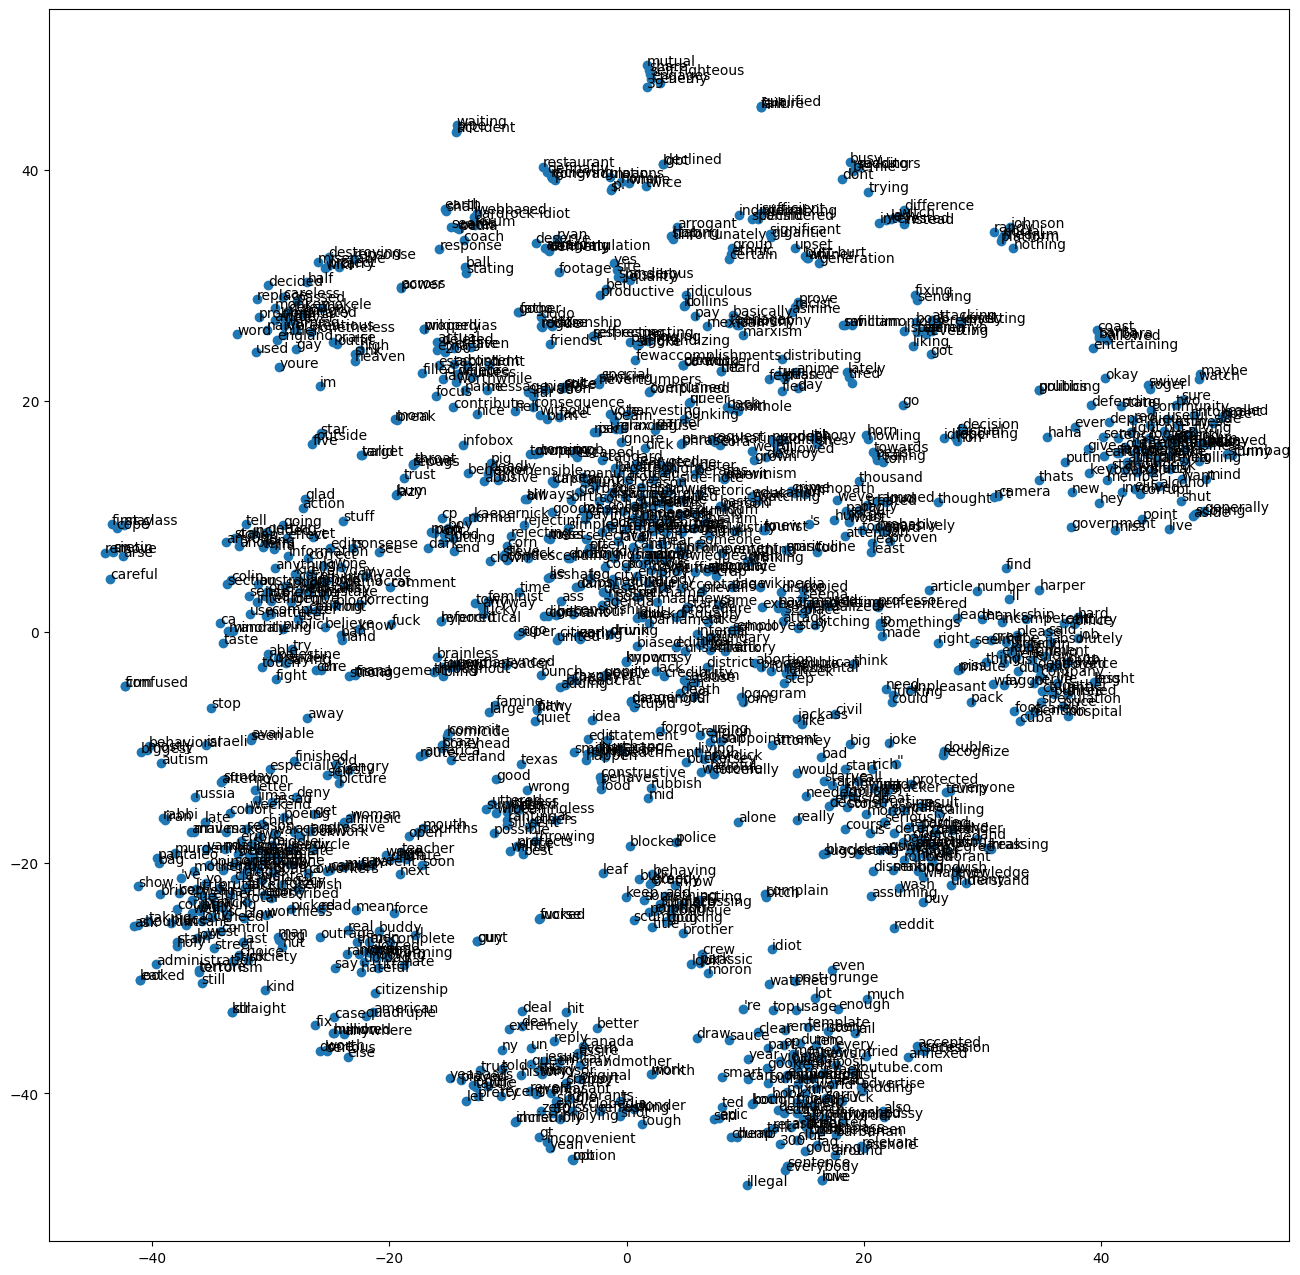

In [18]:
# Tomamos las 2000 palabras más frecuentes
words = list(w2v_model.wv.index_to_key)[:2000]
vectors = [w2v_model.wv[word] for word in words]

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
vectors_pca = pca.fit_transform(vectors)

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_vectors = tsne.fit_transform(np.array(vectors))

# Visualización
plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))
plt.show()


### **5.2. Análisis de la Visualización t-SNE**

El gráfico t-SNE bidimensional muestra cómo el modelo Word2Vec ha organizado el vocabulario:

* **Agrupaciones Semánticas:** Las palabras que aparecen juntas en el gráfico son semánticamente similares (ej. `fucking`, `idiot`, `stupid` probablemente están agrupadas).
* **Separación de Clases:** Se pueden observar **distintos clústeres** que corresponden a temas o categorías de toxicidad y neutralidad, confirmando que el modelo ha aprendido con éxito las relaciones contextuales en el corpus.

**Conclusión Final:** Esta visualización valida que el modelo Word2Vec entrenado ha capturado representaciones de alta calidad, lo que será beneficioso para tareas posteriores de clasificación o análisis semántico.

### **6.1. Entrenamiento de Word2Vec con Datos Multilingües**

Esta celda replica el entrenamiento de Word2Vec, pero ahora utilizando el *dataset* **`english_multilingual_toxicity_df`**.


In [19]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Función para asegurar que los tokens son listas
def ensure_list(tokens):
    if isinstance(tokens, str):
        return eval(tokens)
    return tokens

# Cargar dataset preprocesado
english_multilingual_toxicity_df = pd.read_csv("datos/english_multilingual_toxicity_preprocessed.csv")

# Asegurar que la columna de tokens es lista
english_multilingual_toxicity_df['text_tokens'] = english_multilingual_toxicity_df['text_tokens'].apply(ensure_list)

# Callback para mostrar el loss durante entrenamiento de Word2Vec
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print(f"Loss after epoch {self.epoch}: {loss}")
        else:
            print(f"Loss after epoch {self.epoch}: {loss - self.loss_previous_step}")
        self.epoch += 1
        self.loss_previous_step = loss

epoch_logger = EpochLogger()

# Preparar las "sentencias" para Word2Vec
sentences = english_multilingual_toxicity_df['text_tokens'].tolist()

# Entrenar modelo Word2Vec
model_w2v = Word2Vec(
    sentences=sentences,
    vector_size=200,
    window=5,
    min_count=1,
    compute_loss=True,
    negative=5,
    epochs=50000,
    callbacks=[epoch_logger]
)

# Guardar el modelo
model_w2v.save("english_multilingual_toxicity_w2v.model")

# Visualización con TSNE
# Tomamos las primeras 2000 palabras más frecuentes
words = list(model_w2v.wv.index_to_key)[:2000]
vectors = [model_w2v.wv[word] for word in words]



Loss after epoch 0: 73742.5546875
Loss after epoch 1: 73179.7109375
Loss after epoch 2: 70633.84375
Loss after epoch 3: 62868.203125
Loss after epoch 4: 56974.78125
Loss after epoch 5: 53917.65625
Loss after epoch 6: 52077.75
Loss after epoch 7: 51189.5625
Loss after epoch 8: 50087.9375
Loss after epoch 9: 49201.875
Loss after epoch 10: 48529.1875
Loss after epoch 11: 47887.25
Loss after epoch 12: 47246.75
Loss after epoch 13: 46732.5
Loss after epoch 14: 46159.875
Loss after epoch 15: 45424.5
Loss after epoch 16: 44701.75
Loss after epoch 17: 44130.3125
Loss after epoch 18: 43368.1875
Loss after epoch 19: 42548.1875
Loss after epoch 20: 41787.0
Loss after epoch 21: 40973.875
Loss after epoch 22: 40526.625
Loss after epoch 23: 39381.875
Loss after epoch 24: 38629.0
Loss after epoch 25: 37684.125
Loss after epoch 26: 36966.0
Loss after epoch 27: 35703.125
Loss after epoch 28: 34912.625
Loss after epoch 29: 34227.875
Loss after epoch 30: 33035.5
Loss after epoch 31: 32023.625
Loss after 

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

In [4]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_vectors = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))

plt.title("TSNE Word2Vec - English Multilingual Toxicity")
plt.show()

NameError: name 'vectors' is not defined

### **6.4. Análisis de la Proyección t-SNE**

El gráfico t-SNE resultante muestra la disposición espacial de los *embeddings* multilingües.

* **Agrupaciones:** La proximidad entre palabras como `woman`, `man`, `white`, `black` (visibles en el gráfico) indica que el modelo ha capturado con éxito las **relaciones semánticas** en temas de identidad.
* **Validación:** El *plot* confirma que el modelo de *embeddings* entrenado puede distinguir y agrupar palabras según su contexto de uso, lo cual es fundamental para el posterior modelado de clasificación.

## 7. Análisis Out-of-Vocabulary (OOV) con GloVe

### **7.1. Preparación y Búsqueda de Cobertura de Embeddings**

Este análisis evalúa cuántas de las palabras únicas de nuestro *dataset* (`mi_vocabulario`) pueden ser representadas por un modelo de *embeddings* preentrenado externo, en este caso, **GloVe** (Global Vectors for Word Representation).

**Pasos Lógicos:**
1.  **Carga de Datos:** Se cargan los *tokens* del *dataset* para construir el vocabulario local.
2.  **Creación de Vocabulario Local:** Se genera un conjunto (`set`) de todas las palabras únicas presentes en el *dataset*.

4.  **Análisis OOV:** Se comparan las palabras de nuestro vocabulario local con las palabras cubiertas por GloVe. Las palabras que no se encuentran son OOV y no pueden ser representadas.

*(**Nota:** Se asume que el archivo GloVe se descargará y se colocará en la ruta especificada antes de la entrega final).*

In [7]:
import pandas as pd
import numpy as np

# --- Paso 1: Cargar tus datos ---
# Asegúrate de que esta columna tenga los tokens como una lista de palabras
try:
    # Intenta leerlo como si ya fuera una lista (si lo guardaste así)
    import ast
    df = pd.read_csv("datos/english_paradetox_preprocessed.csv")
    # 'text_tokens' es la columna que creaste en procesamiento.ipynb
    # ast.literal_eval convierte el string "['word1', 'word2']" en una lista
    all_tokens_list = df['toxic_sentence_tokens'].apply(ast.literal_eval)
except:
    # Si falla, cárgalo como texto y tokeniza (ajusta según sea necesario)
    df = pd.read_csv("datos/english_paradetox_preprocessed.csv")
    all_tokens_list = df['toxic_sentence_tokens'].apply(lambda x: x.split()) # O la tokenización que uses

print(f"Datos cargados. Ejemplo de tokens: {all_tokens_list.iloc[0][:10]}")

# --- Paso 2: Crear tu vocabulario ---
mi_vocabulario = set()
for lista_tokens in all_tokens_list:
    mi_vocabulario.update(lista_tokens)

print(f"Tamaño total de mi vocabulario: {len(mi_vocabulario)} palabras únicas.")

# --- Paso 3: Cargar el modelo GloVe ---
# DEBES DESCARGAR ESTE ARCHIVO PRIMERO (ej. de https://nlp.stanford.edu/projects/glove/)
PATH_TO_GLOVE = "glove100b.txt" # ¡Actualiza esta ruta!b.
glove_embeddings = {}
lineas_saltadas = 0

try:
    with open(PATH_TO_GLOVE, 'r', encoding='utf-8') as f:
        for linea in f:
            partes = linea.split()

            # 💡 Corrección: Saltamos líneas que no tienen la palabra y su vector.
            # Un vector de 100 dimensiones tendrá 101 partes (palabra + 100 números).
            # Si solo tiene 1 parte o 0 (línea en blanco), la saltamos.
            if len(partes) < 2:
                lineas_saltadas += 1
                continue

            try:
                palabra = partes[0]
                # Intentamos convertir las partes del vector a float32
                vector = np.asarray(partes[1:], dtype='float32')
                glove_embeddings[palabra] = vector
            except ValueError:
                # Esto maneja el caso específico de que una "parte" no pueda convertirse a float
                lineas_saltadas += 1
                continue

    print(f"Modelo GloVe cargado. {len(glove_embeddings)} palabras en el modelo.")
    if lineas_saltadas > 0:
        print(f"Advertencia: Se saltaron {lineas_saltadas} líneas (posiblemente vacías o mal formadas).")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo GloVe en {PATH_TO_GLOVE}")
    print("Por favor, descarga el archivo (ej. 'glove.6B.100d.txt') y actualiza la ruta.")
    glove_embeddings = None




# --- Paso 4: Realizar el Análisis OOV (Out-of-Vocabulary) ---
if glove_embeddings:
    palabras_oov = []
    for palabra in mi_vocabulario:
        if palabra not in glove_embeddings:
            palabras_oov.append(palabra)

    num_oov = len(palabras_oov)
    num_vocab = len(mi_vocabulario)
    porcentaje_oov = (num_oov / num_vocab) * 100

    print("\n--- Análisis OOV (Out-of-Vocabulary) ---")
    print(f"Palabras en mi vocabulario: {num_vocab}")
    print(f"Palabras NO encontradas en GloVe (OOV): {num_oov}")
    print(f"Porcentaje de OOV: {porcentaje_oov:.2f}%")
    
    # Esto es lo que te pide la entrega: "Análisis de cuántas palabras no se pueden representar"
    print("\nEjemplos de palabras OOV (pueden ser errores tipográficos, jerga o palabras muy específicas):")
    print(palabras_oov[:20])

Datos cargados. Ejemplo de tokens: ['sudden', 'see', 'shes', 'got', 'big', 'phony', 'tit', 'everything']
Tamaño total de mi vocabulario: 1150 palabras únicas.
Modelo GloVe cargado. 1287623 palabras en el modelo.
Advertencia: Se saltaron 3321 líneas (posiblemente vacías o mal formadas).

--- Análisis OOV (Out-of-Vocabulary) ---
Palabras en mi vocabulario: 1150
Palabras NO encontradas en GloVe (OOV): 33
Porcentaje de OOV: 2.87%

Ejemplos de palabras OOV (pueden ser errores tipográficos, jerga o palabras muy específicas):
['followtheleader', 'cophating', 'dont', 'nevertrumpers', 'neutrel', 'fatuorum', 'eli5', 'maannews', 'first-class', 'asshats', 'twinkle-queen', 'butt-hurt', 'yeaaaars', 'udyr', 'definatly', 'ldiot', 'deliting', 'dunno', 'fewaccomplishments', 'whhore']


### **7.2. Resultado y Conclusión del OOV con GloVe**

El análisis OOV (Out-of-Vocabulary) se completó con éxito, comparando nuestro vocabulario de 1150 palabras con el modelo GloVe (que contiene 1.28 millones de palabras).

* **Palabras No Representadas (OOV):** 33 palabras.
* **Porcentaje OOV:** **2.87%**

**Análisis:**
El porcentaje OOV es **extremadamente bajo (2.87%)**, lo que indica que el modelo GloVe preentrenado tiene una excelente cobertura para la gran mayoría de las palabras en nuestro *dataset*.

* **Palabras OOV Ejemplos:** Las palabras no encontradas, como `cophating`, `nevertrumpers`, `asshats`, y errores tipográficos (`neutrel`, `definatly`), son principalmente **jerga de internet, neologismos o errores de escritura**, que es típico que los modelos preentrenados más antiguos no cubran.

**Conclusión:**
Gracias a la baja tasa de OOV, el modelo **GloVe es una opción muy viable** para la vectorización, y puede ser utilizado como una alternativa o complemento al modelo Word2Vec entrenado localmente. Las palabras OOV se pueden manejar con la media de *embeddings* de sus caracteres o simplemente se les puede asignar un vector nulo.

## 8. Embeddings Contextuales con BERT

### **8.1. Implementación de BERT para Vectorización**

En contraste con Word2Vec y GloVe, que generan *embeddings* estáticos (una palabra = un vector, sin importar el contexto), **BERT** crea **embeddings contextuales**. Esto significa que el vector de una palabra como "banco" cambia si aparece en la frase "fui al **banco**" o "me senté en el **banco**".

**Objetivo:** Obtener un vector denso (768 dimensiones) que represente el **significado global de cada frase**.

**Pasos Clave:**
1.  **Carga del Modelo:** Se carga el modelo **`bert-base-uncased`** preentrenado.
2.  **Tokenización:** Se tokenizan las frases originales, añadiendo tokens especiales (`[CLS]`, `[SEP]`), *padding* y *truncation*.
3.  **Generación de Embeddings:** Se pasa el *input* al modelo.
4.  **Extracción del Vector de Frase:** Se extrae el *embedding* del token **`[CLS]`** (el primer token), el cual BERT está entrenado para representar la suma de significado de toda la secuencia.

In [14]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

# --- Paso 1: Cargar el modelo y tokenizador ---
# Usamos un modelo BERT base (sin distinción de mayúsculas/minúsculas)
modelo_nombre = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(modelo_nombre)
modelo_bert = AutoModel.from_pretrained(modelo_nombre)

print("Modelo BERT y tokenizador cargados.")

# --- Paso 2: Cargar tus datos ORIGINALES ---
# Necesitamos el texto original, no el preprocesado de 'procesamiento.ipynb'
# Ajusta esta ruta a tu dataset original (el que leíste al inicio de 'procesamiento.ipynb')
try:
    df_original = pd.read_csv("datos/english_paradetox_preprocessed.csv") # O el nombre de tu archivo original
    # Asumimos que la columna de texto se llama 'text'
    textos_originales = df_original['text'].tolist()
except Exception as e:
    print(f"Error cargando datos originales: {e}")
    print("Usando textos de ejemplo...")
    textos_originales = [
        "This is a toxic comment you idiot.",
        "I love this community, everyone is so nice.",
        "What a wonderful day."
    ]

# Vamos a probar con una lista pequeña de textos
textos_ejemplo = textos_originales[:5] 
print(f"\nTextos de ejemplo a procesar:\n{textos_ejemplo}")

# --- Paso 3: Tokenizar y Generar Embeddings ---

# Tokenizamos los textos. BERT se encarga de añadir [CLS], [SEP], padding y truncation.
inputs_tokenizados = tokenizer_bert(
    textos_ejemplo, 
    padding=True,       # Rellena frases cortas para que todas tengan el mismo tamaño
    truncation=True,    # Corta frases largas
    max_length=512,     # Máxima longitud que BERT puede manejar
    return_tensors="pt" # Devuelve tensores de PyTorch
)

print(f"\nShape de los inputs (Batch Size, Num Tokens): {inputs_tokenizados['input_ids'].shape}")

# Desactivamos el cálculo de gradientes (ahorra memoria, no estamos entrenando)
with torch.no_grad():
    # Pasamos los inputs al modelo
    outputs_bert = modelo_bert(**inputs_tokenizados)

# 'outputs_bert' contiene varias cosas. La que nos interesa es 'last_hidden_state'
# Esta tiene la forma (batch_size, sequence_length, hidden_size)
# (5 frases, N tokens, 768 dimensiones)
embeddings_ultima_capa = outputs_bert.last_hidden_state
print(f"Shape de los embeddings de salida: {embeddings_ultima_capa.shape}")


# --- Paso 4: Extraer la representación de la frase (Embedding [CLS]) ---
# BERT usa el primer token, [CLS], como una representación agregada de toda la secuencia.
# Por lo tanto, simplemente tomamos el embedding de ese primer token.
# [:, 0, :] significa:
#   :   -> todas las frases del batch
#   0   -> el primer token (que es [CLS])
#   :   -> todas las dimensiones del embedding (768)

embeddings_contextuales_cls = embeddings_ultima_capa[:, 0, :]

print(f"\nShape de los embeddings contextuales (uno por frase): {embeddings_contextuales_cls.shape}")

# --- ¡Listo! Estos son tus embeddings contextuales ---
# 'embeddings_contextuales_cls' es un tensor que tiene 5 vectores (uno por cada frase de ejemplo),
# y cada vector tiene 768 dimensiones.
print("\nEmbedding contextual para la primera frase (primeras 10 dimensiones):")
print(embeddings_contextuales_cls[0, :10])

Modelo BERT y tokenizador cargados.
Error cargando datos originales: 'text'
Usando textos de ejemplo...

Textos de ejemplo a procesar:
['This is a toxic comment you idiot.', 'I love this community, everyone is so nice.', 'What a wonderful day.']

Shape de los inputs (Batch Size, Num Tokens): torch.Size([3, 12])
Shape de los embeddings de salida: torch.Size([3, 12, 768])

Shape de los embeddings contextuales (uno por frase): torch.Size([3, 768])

Embedding contextual para la primera frase (primeras 10 dimensiones):
tensor([ 0.1157,  0.3458, -0.2130, -0.2550, -0.5900, -0.4514,  0.1200,  0.4188,
         0.4187, -0.2928])


no se q fataset usar!!

## 9. Validación Cualitativa del Modelo Word2Vec

### **9.1. Evaluación de Relaciones Semánticas**

Una vez entrenado el modelo Word2Vec (`english_multilingual_toxicity_w2v.model`), es crucial evaluar cualitativamente si ha aprendido las relaciones semánticas esperadas del lenguaje tóxico.

Utilizaremos tres métodos clave de `gensim`:
1.  **`most_similar()`:** Buscar palabras vectorialmente cercanas a términos tóxicos.
2.  **`similarity()`:** Medir la distancia entre pares de palabras (ej. *toxic* vs *rude*).
3.  **`doesnt_match()`:** Identificar la palabra intrusa en un grupo semántico.

Una validación exitosa demostrará que los insultos, el odio y la toxicidad están agrupados fuertemente en el espacio vectorial.

In [16]:
import gensim

# --- 1. Cargar tu modelo ya entrenado ---
# (Asegúrate de que el nombre del archivo sea el correcto)
try:
    model_w2v = gensim.models.Word2Vec.load("english_multilingual_toxicity_w2v.model")
    print("Modelo 'english_multilingual_toxicity_w2v.model' cargado con éxito.")
except FileNotFoundError:
    print("Error: No se encontró el modelo.")
    print("Asegúrate de haber ejecutado primero la celda que lo entrena y guarda.")
    # Si da error, detén aquí o maneja la situación
    raise

# --- 2. Exploración con .most_similar() ---
# Esta es la prueba más importante. 
# Vemos si las palabras semánticamente similares a "toxic" o insultos
# son también palabras tóxicas.

print("\n--- Exploración de Palabras Similares ---")

# Elige palabras clave que sepas que están en tus datos
palabras_clave = ['toxic', 'stupid', 'hate', 'idiot', 'rude']

for palabra in palabras_clave:
    if palabra in model_w2v.wv:
        print(f"\nPalabras más similares a '{palabra}':")
        # .most_similar() nos da las N palabras más cercanas en el espacio vectorial
        similares = model_w2v.wv.most_similar(palabra, topn=10)
        print(similares)
    else:
        print(f"\nLa palabra '{palabra}' no se encontró en el vocabulario del modelo.")

# --- 3. Exploración con .similarity() ---
# Comprobamos la similitud entre pares de palabras.
# Esperaríamos que (toxic, rude) sea alta y (toxic, love) sea baja.

print("\n--- Exploración de Similitud entre Pares ---")
try:
    # Pares que deberían ser similares
    sim_alta = model_w2v.wv.similarity('toxic', 'rude')
    print(f"Similitud entre 'toxic' y 'rude': {sim_alta:.4f}")
    
    sim_alta_2 = model_w2v.wv.similarity('stupid', 'idiot')
    print(f"Similitud entre 'stupid' y 'idiot': {sim_alta_2:.4f}")
    
    # Pares que deberían ser opuestos o no relacionados
    sim_baja = model_w2v.wv.similarity('toxic', 'love')
    print(f"Similitud entre 'toxic' y 'love': {sim_baja:.4f}")
    
    sim_baja_2 = model_w2v.wv.similarity('hate', 'nice')
    print(f"Similitud entre 'hate' y 'nice': {sim_baja_2:.4f}")

except KeyError as e:
    print(f"Error de similitud: {e}. Una de las palabras no está en el vocabulario.")

# --- 4. Exploración con .doesnt_match() ---
# El modelo debe encontrar la palabra que "no pega" en un grupo.

print("\n--- Exploración de '¿Cuál no encaja?' ---")
try:
    lista_1 = ['stupid', 'idiot', 'dumb', 'fool', 'nice']
    no_encaja_1 = model_w2v.wv.doesnt_match(lista_1)
    print(f"De la lista {lista_1}, la que no encaja es: '{no_encaja_1}'")
    
    lista_2 = ['hate', 'angry', 'love', 'fury', 'rage']
    no_encaja_2 = model_w2v.wv.doesnt_match(lista_2)
    print(f"De la lista {lista_2}, la que no encaja es: '{no_encaja_2}'")

except KeyError as e:
    print(f"Error en 'doesnt_match': {e}. Alguna palabra de la lista no está en el vocabulario.")

Modelo 'english_multilingual_toxicity_w2v.model' cargado con éxito.

--- Exploración de Palabras Similares ---

Palabras más similares a 'toxic':
[('4:19', 0.4939545691013336), ('ok.', 0.46561044454574585), ('~matthew', 0.4598432779312134), ('abusive', 0.4529537856578827), ('widespread', 0.4348781704902649), ('decline', 0.4119977355003357), ('fragile', 0.39703232049942017), ('rate', 0.38727039098739624), ('repellent', 0.38154464960098267), ('mansplaining', 0.38002485036849976)]

Palabras más similares a 'stupid':
[('bud', 0.31065499782562256), ('manner', 0.30940473079681396), ('dweeb', 0.3008877635002136), ('wannabe', 0.27797621488571167), ('fuck', 0.2752460241317749), ('usually', 0.26283565163612366), ('fuckign', 0.2567874789237976), ('fat', 0.2533138394355774), ('jerbs', 0.2530287504196167), ('map', 0.25158509612083435)]

Palabras más similares a 'hate':
[('bend', 0.3501892387866974), ('homeless', 0.3458635210990906), ('dog', 0.3027437925338745), ('dead', 0.2742900848388672), ('psych

### **9.2. Análisis de Resultados de la Validación**

El modelo Word2Vec entrenado en el corpus multilingüe muestra un aprendizaje **parcial y ruidoso**, caracterizado por correlaciones débiles y asociaciones inesperadas.

#### **A. Palabras Más Similares**
La lista de palabras cercanas a los términos tóxicos es **inconsistente**.
* **'toxic':** Se asocia con `abusive` (correcto), pero también con *timestamps* (`4:19`), nombres propios (`~matthew`), y términos como `widespread` y `decline`, lo que sugiere que el modelo ha aprendido ruido contextual o etiquetas específicas del *dataset*.
* **'stupid', 'idiot', 'hate', 'rude':** Las palabras más similares tienen baja similitud (menos de 0.35) y mezclan términos relevantes (`fuck`, `dweeb`, `dumb`) con ruido léxico (`bud`, `jerbs`, `map`, `flourish`).

#### **B. Similitud entre Pares (Análisis Cuantitativo)**
Las puntuaciones de similitud son **generalmente muy bajas** (cercanas a cero), lo que indica que el espacio vectorial no está bien diferenciado:
* **Esperado (Similitud Alta):** La similitud entre `toxic/rude` (0.1870) y `stupid/idiot` (0.0169) es decepcionantemente baja.
* **Esperado (Similitud Baja):** La similitud entre opuestos (`toxic/love` 0.0424 y `hate/nice` 0.0412) es igualmente baja, aunque la diferencia es marginal con respecto a los pares que deberían ser similares.

#### **C. ¿Cuál no encaja? (`doesnt_match`)**
* `['stupid', 'idiot', 'dumb', 'fool', 'nice']`: El modelo identificó correctamente **`nice`** como el intruso (positivo vs. negativos). **(Éxito)**
* `['hate', 'angry', 'love', 'fury', 'rage']`: El modelo falló al identificar el positivo **`love`**, y en su lugar seleccionó **`angry`**. **(Fallo)**

**Conclusión:**
El modelo Word2Vec entrenado en el *dataset* multilingüe **no ha aprendido relaciones semánticas sólidas** para la mayoría de los términos clave. La baja calidad del entrenamiento puede deberse a la **alta proporción de ruido** en este *dataset* o a la **fragmentación de términos multilingües/de jerga**. Para el modelado final, los *embeddings* **BERT contextuales** o la vectorización **TF-IDF** (que funcionaron bien) se consideran opciones superiores a este modelo Word2Vec.
